 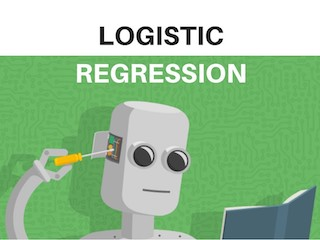

<h1>Sprint 10. Aprenentatge Supervisat - Classificació</h1>

<h2>Libraries</h2>

In [192]:
#Data Manipulation
import pandas as pd 
import numpy as np

#Data Modeling
import category_encoders as ce
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve
from sklearn.metrics import mean_squared_error, confusion_matrix,roc_curve 
from sklearn.metrics import roc_auc_score,plot_confusion_matrix, accuracy_score,f1_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt 

<h2>Notebook Function</h2>

In [2]:
#1: Percent of nan values
def percent_nan(df):
    return round((df.isnull().sum()/df.shape[0])*100,2) 

In [3]:
#2: impute nan with zeros
def imputation_nan_zero(df,list_col):
    for i in list_col:
        df[i] = df[i].fillna(0) 

In [4]:
#3: function to return the value of the taxi time by airport   
def airport(lista,df,feature,index):
    airport = df[feature].iloc[index]
    for x,val in enumerate(lista.index):
        if val == airport:
            return lista.iloc[x]

In [5]:
#4: imput  from the list values 
def imputation_value (lista,df,col):
    for i in lista:
        df[col] = df[col].fillna(i,limit=1) 

In [6]:
#5: Transform type 
def astype_convertion(df,cols,dtype):
    df[cols] = df[cols].astype(dtype)

In [7]:
#6: correlation matrix 

def matrix_plot (df,name):

    fig, ax = plt.subplots(figsize=(15, 15))

# Data
    corr_matrix= df.select_dtypes(include=[np.number]).corr(method='pearson')
    half_matrix = np.triu(corr_matrix)

# Heatmap Matrix
    sns.heatmap(corr_matrix, annot=True, mask = half_matrix,
                cmap=sns.color_palette('YlOrBr', as_cmap=True), 
                annot_kws = {"size": 10})
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,horizontalalignment = 'right',)
    ax.set_yticklabels(ax.get_yticklabels(),rotation = 0,horizontalalignment = 'right',)
    ax.tick_params(labelsize = 15)
    fig.suptitle(name, fontsize = 13, fontweight = "bold")
    plt.show()
    

In [8]:
#7: Variance Inflation Factor(VIF)
def vif(Z):
    vif_data = pd.DataFrame()  
    vif_data['feature'] = Z.columns  
    vif_data['Variance Inflation Factor(VIF)'] = [variance_inflation_factor(Z.values, i) 
                                                  for i in range(len(Z.columns))]
    return vif_data

In [9]:
#8 convert time to ordinal value
def time_to_ordinal(df,col,newCol):
    df[newCol] = df[col].apply(lambda x: x.toordinal())

In [10]:
#9 plot confusion matrix and roc

def subplots_ROC_CM(main_title,rtitle,mtitle,mod,accuracy,auc,matrix,model,Xtest,ytest):
    fig , axes = plt.subplots(1,2,figsize=(10,8))
    
    
    y_pred_prob1_rs = mod.predict_proba(Xtest)[:,1]
    fpr1_rs, tpr1_rs, thresholds1_rs = roc_curve(ytest, y_pred_prob1_rs)
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].plot(fpr1_rs, tpr1_rs, label='Logistic Regression')
    axes[0].legend(loc="best")
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_xlabel('True Positive Rate')
    axes[0].set_title(rtitle + "\n" +
             "AUC : {0:.2%}".format(accuracy.get(model)))
    
    
    group_counts = ["{0:0.0f}".format(v) for v in matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) 
                     for value in matrix.flatten()/np.sum(matrix)]
    labels = [f"{ant1}\n{ant2}" for ant1, ant2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(matrix, annot=labels, fmt='', 
                 cmap='Blues', ax=axes[1])
    axes[1].set_title(mtitle+ "\n" +"Accuracy Score: {0:.2%}".format(auc.get(model))) 
    axes[1].set_xlabel('\nPredicted Values')
    axes[1].set_ylabel('Actual Values ')
    axes[1].xaxis.set_ticklabels(['False','True'])
    axes[1].yaxis.set_ticklabels(['False','True'])
    
    plt.suptitle(main_title)
    plt.show()

**This dataset is composed by the following variables:**<br>
**Year** 2008 <br>
**Month** 1-12 <br>
**DayofMonth** 1-31 <br>
**DayOfWeek** 1 (Monday) - 7 (Sunday)<br>
**DepTime** actual departure time (local, hhmm)<br>
**CRSDepTime** scheduled departure time (local, hhmm)<br>
**ArrTime** actual arrival time (local, hhmm)<br>
**CRSArrTime** scheduled arrival time (local, hhmm)<br>
**UniqueCarrier** unique carrier code<br>
**FlightNum** flight number<br>
**TailNum** plane tail number: aircraft registration, unique aircraft identifier<br>
**ActualElapsedTime** in minutes<br>
**CRSElapsedTime** in minutes<br>
**AirTime** in minutes<br>
**ArrDelay** arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).<br>
**DepDelay** departure delay, in minutes<br>
**Origin** origin IATA airport code<br>
**Dest** destination IATA airport code<br>
**Distance** in miles<br>
**TaxiIn** taxi in time, in minutes<br>
**TaxiOut** taxi out time in minutes<br>
**Cancelled** was the flight cancelled<br>
**CancellationCode** reason for cancellation (A = carrier, B = weather, C = NAS, D = security) <br>
**Diverted** 1 = yes, 0 = no<br>
**CarrierDelay in minutes:** Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.<br>
**WeatherDelay in minutes:** Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.<br>
**NASDelay in minutes:** Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.<br>
**SecurityDelay in minutes:** Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.<br>
**LateAircraftDelay in minutes:** Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.<br>

In [11]:
data = pd.read_csv("DelayedFlights.csv",
                   parse_dates=[["Year", "Month","DayofMonth"]])

In [12]:
data.head().T

,0,1,2,3,4
Year_Month_DayofMonth,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00
Unnamed: 0,0,1,2,4,5
DayOfWeek,4,4,4,4,4
DepTime,2003.0,754.0,628.0,1829.0,1940.0
CRSDepTime,1955,735,620,1755,1915
ArrTime,2211.0,1002.0,804.0,1959.0,2121.0
CRSArrTime,2225,1000,750,1925,2110
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,335,3231,448,3920,378
TailNum,N712SW,N772SW,N428WN,N464WN,N726SW


<h2> DEA </h2>

In [13]:
df = data.copy()

In [14]:
df.rename(columns={"Year_Month_DayofMonth":"Date"},inplace=True)

In [15]:
df.head().T

,0,1,2,3,4
Date,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00
Unnamed: 0,0,1,2,4,5
DayOfWeek,4,4,4,4,4
DepTime,2003.0,754.0,628.0,1829.0,1940.0
CRSDepTime,1955,735,620,1755,1915
ArrTime,2211.0,1002.0,804.0,1959.0,2121.0
CRSArrTime,2225,1000,750,1925,2110
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,335,3231,448,3920,378
TailNum,N712SW,N772SW,N428WN,N464WN,N726SW


In [16]:
data.shape

(1936758, 28)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 28 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Year_Month_DayofMonth  datetime64[ns]
 1   Unnamed: 0             int64         
 2   DayOfWeek              int64         
 3   DepTime                float64       
 4   CRSDepTime             int64         
 5   ArrTime                float64       
 6   CRSArrTime             int64         
 7   UniqueCarrier          object        
 8   FlightNum              int64         
 9   TailNum                object        
 10  ActualElapsedTime      float64       
 11  CRSElapsedTime         float64       
 12  AirTime                float64       
 13  ArrDelay               float64       
 14  DepDelay               float64       
 15  Origin                 object        
 16  Dest                   object        
 17  Distance               int64         
 18  TaxiIn                

In [18]:
df.isna().sum()

Date                      0
Unnamed: 0                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                7110
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   5
ActualElapsedTime      8387
CRSElapsedTime          198
AirTime                8387
ArrDelay               8387
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                 7110
TaxiOut                 455
Cancelled                 0
CancellationCode          0
Diverted                  0
CarrierDelay         689270
WeatherDelay         689270
NASDelay             689270
SecurityDelay        689270
LateAircraftDelay    689270
dtype: int64

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1936758.0,3.341651e+06,2.066065e+06,0.0,1517452.5,3242558.0,4972466.75,7009727.0
DayOfWeek,1936758.0,3.984827e+00,1.995966e+00,1.0,2.0,4.0,6.00,7.0
DepTime,1936758.0,1.518534e+03,4.504853e+02,1.0,1203.0,1545.0,1900.00,2400.0
CRSDepTime,1936758.0,1.467473e+03,4.247668e+02,0.0,1135.0,1510.0,1815.00,2359.0
ArrTime,1929648.0,1.610141e+03,5.481781e+02,1.0,1316.0,1715.0,2030.00,2400.0
CRSArrTime,1936758.0,1.634225e+03,4.646347e+02,0.0,1325.0,1705.0,2014.00,2400.0
FlightNum,1936758.0,2.184263e+03,1.944702e+03,1.0,610.0,1543.0,3422.00,9742.0
ActualElapsedTime,1928371.0,1.333059e+02,7.206007e+01,14.0,80.0,116.0,165.00,1114.0
CRSElapsedTime,1936560.0,1.343027e+02,7.134144e+01,-25.0,82.0,116.0,165.00,660.0
AirTime,1928371.0,1.082771e+02,6.864261e+01,0.0,58.0,90.0,137.00,1091.0


In [20]:
df.describe(include="object").T

,count,unique,top,freq
UniqueCarrier,1936758,20,WN,377602
TailNum,1936753,5366,N325SW,965
Origin,1936758,303,ATL,131613
Dest,1936758,304,ORD,108984
CancellationCode,1936758,4,N,1936125


In [21]:
#use the function (1) to find the percent of nan values
percent_nan(df)

Date                  0.00
Unnamed: 0            0.00
DayOfWeek             0.00
DepTime               0.00
CRSDepTime            0.00
ArrTime               0.37
CRSArrTime            0.00
UniqueCarrier         0.00
FlightNum             0.00
TailNum               0.00
ActualElapsedTime     0.43
CRSElapsedTime        0.01
AirTime               0.43
ArrDelay              0.43
DepDelay              0.00
Origin                0.00
Dest                  0.00
Distance              0.00
TaxiIn                0.37
TaxiOut               0.02
Cancelled             0.00
CancellationCode      0.00
Diverted              0.00
CarrierDelay         35.59
WeatherDelay         35.59
NASDelay             35.59
SecurityDelay        35.59
LateAircraftDelay    35.59
dtype: float64

<h2> Preproccesing Data</h2>

In [22]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [23]:
df.sample(10).T

,965126,773852,1135581,1576678,1282253,1647324,1641344,1645169,800131,1774668
Date,2008-06-13 00:00:00,2008-05-08 00:00:00,2008-07-01 00:00:00,2008-10-16 00:00:00,2008-08-17 00:00:00,2008-11-30 00:00:00,2008-11-23 00:00:00,2008-11-30 00:00:00,2008-05-09 00:00:00,2008-12-26 00:00:00
DayOfWeek,5,4,2,4,7,7,7,7,5,5
DepTime,946.0,2045.0,2226.0,1738.0,1658.0,1606.0,1821.0,1153.0,730.0,1135.0
CRSDepTime,845,2015,2050,1435,1650,1445,1805,1120,715,1055
ArrTime,1108.0,2258.0,121.0,2045.0,1914.0,1819.0,2015.0,1250.0,1052.0,1407.0
CRSArrTime,1010,2234,2346,1746,1910,1710,2020,1220,1020,1319
UniqueCarrier,UA,OH,OO,DL,WN,XE,WN,WN,US,XE
FlightNum,635,5417,6436,1403,1928,2806,1519,3128,817,2352
TailNum,N347UA,N818CA,N405SW,N906DL,N750SA,N14116,N628SW,N643SW,N444US,N13133
ActualElapsedTime,82.0,133.0,115.0,187.0,136.0,193.0,114.0,57.0,142.0,152.0


**The original dataframe has more than 35% of NaN's values in the delay features, I will impute the delay features observation with Zero because these the NaN's represents NO delay in anyform.** 

**There are observations in the delay features with zeros but these have at least one value delay more than zero, there're others observation that all its values are COMPLETAR MAS TARDE**

In [24]:
features_imputation_zero = ["WeatherDelay","CarrierDelay","NASDelay","SecurityDelay","LateAircraftDelay"]   

In [25]:
#use the function (2)to imputate nan with zeros
imputation_nan_zero(df,features_imputation_zero)

In [26]:
#use the function (1) to find the percent of nan values
percent_nan(df)

Date                 0.00
DayOfWeek            0.00
DepTime              0.00
CRSDepTime           0.00
ArrTime              0.37
CRSArrTime           0.00
UniqueCarrier        0.00
FlightNum            0.00
TailNum              0.00
ActualElapsedTime    0.43
CRSElapsedTime       0.01
AirTime              0.43
ArrDelay             0.43
DepDelay             0.00
Origin               0.00
Dest                 0.00
Distance             0.00
TaxiIn               0.37
TaxiOut              0.02
Cancelled            0.00
CancellationCode     0.00
Diverted             0.00
CarrierDelay         0.00
WeatherDelay         0.00
NASDelay             0.00
SecurityDelay        0.00
LateAircraftDelay    0.00
dtype: float64

<h3>Imputation of TaxiOut</h3>

In [27]:
# group by origin and get the mean of the features 
grouped_by_origin = round(df.groupby("Origin").mean(),0)
grouped_by_origin

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
Origin,,,,,,,,,,,,,,,,,,,,,
ABE,4.0,1412.0,1316.0,1561.0,1471.0,5096.0,124.0,122.0,98.0,61.0,...,590.0,10.0,15.0,0.0,0.0,18.0,4.0,21.0,0.0,15.0
ABI,4.0,1191.0,1079.0,1286.0,1176.0,3477.0,57.0,58.0,38.0,66.0,...,158.0,9.0,10.0,0.0,0.0,33.0,11.0,9.0,0.0,11.0
ABQ,4.0,1531.0,1479.0,1696.0,1668.0,1810.0,108.0,110.0,91.0,34.0,...,643.0,6.0,11.0,0.0,0.0,7.0,1.0,4.0,0.0,19.0
ABY,4.0,1434.0,1355.0,1504.0,1446.0,4736.0,57.0,55.0,37.0,51.0,...,146.0,11.0,9.0,0.0,0.0,19.0,8.0,14.0,0.0,8.0
ACK,4.0,1462.0,1362.0,1587.0,1499.0,3118.0,83.0,83.0,52.0,66.0,...,210.0,11.0,20.0,0.0,0.0,16.0,6.0,23.0,0.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WYS,4.0,1735.0,1694.0,1856.0,1826.0,3634.0,77.0,84.0,61.0,18.0,...,273.0,5.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
XNA,4.0,1339.0,1251.0,1528.0,1457.0,3988.0,116.0,114.0,90.0,57.0,...,607.0,10.0,16.0,0.0,0.0,15.0,3.0,18.0,0.0,19.0
YAK,4.0,1601.0,1501.0,1652.0,1590.0,63.0,49.0,49.0,37.0,55.0,...,206.0,4.0,8.0,0.0,0.0,5.0,0.0,3.0,0.0,45.0


The TaxiOut is the time spent by a aircraft between its initial movement from the gate and the actual take-off time. This is important because in congested airports its value may increase due to the wait for take-off. 

In [28]:
#get only the TaxiOut
taxiOut_by_origin = grouped_by_origin["TaxiOut"]
taxiOut_by_origin

Origin
ABE    15.0
ABI    10.0
ABQ    11.0
ABY     9.0
ACK    20.0
       ... 
WYS    11.0
XNA    16.0
YAK     8.0
YKM    10.0
YUM    13.0
Name: TaxiOut, Length: 303, dtype: float64

In [30]:
#get the indexes of the row with taxiOut as NaN values
index_taxiout_nan = df[df["TaxiOut"].isnull()].index
index_taxiout_nan

Int64Index([1546593, 1547161, 1547178, 1548271, 1548430, 1550787, 1554099,
            1556173, 1559220, 1561026,
            ...
            1930247, 1930288, 1930321, 1930326, 1930330, 1931769, 1933249,
            1934590, 1935491, 1935876],
           dtype='int64', length=455)

In [31]:
#Use function (3) to get the taxiOut time and then append the
# values in a  list. 
n_values_taxiOut = []
for i in index_taxiout_nan:
    x = airport(taxiOut_by_origin,df,"Origin",i)
    n_values_taxiOut.append(x)

In [32]:
#Use function (4) to imput the TaxiOut takes time because it impute a value at time 
#This way the imputation is individual 
imputation_value(n_values_taxiOut,df,"TaxiOut")

In [33]:
#use the function (1) to find the percent of nan values
percent_nan(df)

Date                 0.00
DayOfWeek            0.00
DepTime              0.00
CRSDepTime           0.00
ArrTime              0.37
CRSArrTime           0.00
UniqueCarrier        0.00
FlightNum            0.00
TailNum              0.00
ActualElapsedTime    0.43
CRSElapsedTime       0.01
AirTime              0.43
ArrDelay             0.43
DepDelay             0.00
Origin               0.00
Dest                 0.00
Distance             0.00
TaxiIn               0.37
TaxiOut              0.00
Cancelled            0.00
CancellationCode     0.00
Diverted             0.00
CarrierDelay         0.00
WeatherDelay         0.00
NASDelay             0.00
SecurityDelay        0.00
LateAircraftDelay    0.00
dtype: float64

<h3>Imputation of TaxiIn</h3>

In [34]:
# group by Dest and get the mean of the features 
grouped_by_destination = round(df.groupby("Dest").mean(),0)
grouped_by_destination

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
Dest,,,,,,,,,,,,,,,,,,,,,
ABE,4.0,1641.0,1571.0,1664.0,1763.0,4700.0,102.0,104.0,76.0,49.0,...,566.0,5.0,22.0,0.0,0.0,19.0,3.0,7.0,0.0,18.0
ABI,4.0,1692.0,1627.0,1762.0,1718.0,3541.0,54.0,54.0,34.0,37.0,...,158.0,3.0,16.0,0.0,0.0,14.0,5.0,4.0,0.0,11.0
ABQ,4.0,1543.0,1493.0,1609.0,1644.0,1730.0,115.0,118.0,96.0,32.0,...,682.0,5.0,14.0,0.0,0.0,10.0,1.0,3.0,0.0,16.0
ABY,4.0,1569.0,1511.0,1601.0,1599.0,4729.0,56.0,54.0,28.0,47.0,...,146.0,4.0,24.0,0.0,0.0,22.0,9.0,10.0,0.0,5.0
ACK,4.0,1506.0,1464.0,1501.0,1602.0,3261.0,89.0,87.0,45.0,59.0,...,211.0,6.0,39.0,0.0,0.0,20.0,2.0,15.0,0.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WYS,4.0,1390.0,1333.0,1527.0,1498.0,3633.0,81.0,89.0,59.0,24.0,...,273.0,3.0,19.0,0.0,0.0,18.0,3.0,1.0,0.0,1.0
XNA,4.0,1594.0,1528.0,1673.0,1685.0,4001.0,110.0,110.0,85.0,47.0,...,565.0,5.0,21.0,0.0,0.0,17.0,4.0,6.0,0.0,19.0
YAK,4.0,1406.0,1319.0,1498.0,1414.0,63.0,55.0,54.0,38.0,53.0,...,205.0,4.0,13.0,0.0,0.0,12.0,1.0,3.0,0.0,34.0


TaxiIn is the time of movement of the aircraft from the runway to the gate after it landed. 

In [35]:
#get only the TaxiOut
taxiIn_by_origin = grouped_by_destination["TaxiIn"]
taxiIn_by_origin

Dest
ABE    5.0
ABI    3.0
ABQ    5.0
ABY    4.0
ACK    6.0
      ... 
WYS    3.0
XNA    5.0
YAK    4.0
YKM    4.0
YUM    5.0
Name: TaxiIn, Length: 304, dtype: float64

In [36]:
#get the indexes of the row with taxiOut as NaN values
index_taxiIn_nan = df[df["TaxiIn"].isnull()].index
index_taxiIn_nan

Int64Index([   1280,    1372,    1776,    1831,    2244,    2245,    2720,
               2831,    3075,    3179,
            ...
            1930326, 1930330, 1931769, 1933249, 1933981, 1934590, 1935491,
            1935651, 1935876, 1936470],
           dtype='int64', length=7110)

In [37]:
#Use function (3) to get the taxiOut time and then append the
# values in a  list. 
n_values_taxiIn = []
for i in index_taxiIn_nan:
    x = airport(taxiIn_by_origin,df,"Dest",i)
    n_values_taxiIn.append(x)

In [38]:
#Use function (4) to imput the TaxiIn takes time because it impute a value at time 
#This way the imputation is individual 
imputation_value(n_values_taxiIn,df,"TaxiIn")

In [39]:
#use the function (1) to find the percent of nan values
percent_nan(df)

Date                 0.00
DayOfWeek            0.00
DepTime              0.00
CRSDepTime           0.00
ArrTime              0.37
CRSArrTime           0.00
UniqueCarrier        0.00
FlightNum            0.00
TailNum              0.00
ActualElapsedTime    0.43
CRSElapsedTime       0.01
AirTime              0.43
ArrDelay             0.43
DepDelay             0.00
Origin               0.00
Dest                 0.00
Distance             0.00
TaxiIn               0.00
TaxiOut              0.00
Cancelled            0.00
CancellationCode     0.00
Diverted             0.00
CarrierDelay         0.00
WeatherDelay         0.00
NASDelay             0.00
SecurityDelay        0.00
LateAircraftDelay    0.00
dtype: float64

 <h3>Imputation of ArrTime</h3>

In [40]:
#get the indexes of the row with taxiOut as NaN values
index_ArrTime_nan = df[df["ArrTime"].isnull()].index
index_ArrTime_nan

Int64Index([   1280,    1372,    1776,    1831,    2244,    2245,    2720,
               2831,    3075,    3179,
            ...
            1930326, 1930330, 1931769, 1933249, 1933981, 1934590, 1935491,
            1935651, 1935876, 1936470],
           dtype='int64', length=7110)

In [41]:
df.iloc[1936470]

Date                 2008-12-12 00:00:00
DayOfWeek                              5
DepTime                            703.0
CRSDepTime                           630
ArrTime                              NaN
CRSArrTime                           734
UniqueCarrier                         DL
FlightNum                           1372
TailNum                           N908DE
ActualElapsedTime                    NaN
CRSElapsedTime                      64.0
AirTime                              NaN
ArrDelay                             NaN
DepDelay                            33.0
Origin                               LGA
Dest                                 BOS
Distance                             185
TaxiIn                               NaN
TaxiOut                             33.0
Cancelled                              1
CancellationCode                       B
Diverted                               0
CarrierDelay                         0.0
WeatherDelay                         0.0
NASDelay        

I have reviewed some observations and concluded that the missing values are in ArrTime is because these flight are Diverted or Cancelled. The percent of the data is small so I will drop them because maybe it could be complicated to calculate them and the results can be wrong affecting the final result.

In [42]:
#drop the NaN's 
df.dropna(subset=["ArrTime"],inplace=True)

In [43]:
 #use the function (1) to find the percent of nan values
percent_nan(df)

Date                 0.00
DayOfWeek            0.00
DepTime              0.00
CRSDepTime           0.00
ArrTime              0.00
CRSArrTime           0.00
UniqueCarrier        0.00
FlightNum            0.00
TailNum              0.00
ActualElapsedTime    0.07
CRSElapsedTime       0.00
AirTime              0.07
ArrDelay             0.07
DepDelay             0.00
Origin               0.00
Dest                 0.00
Distance             0.00
TaxiIn               0.00
TaxiOut              0.00
Cancelled            0.00
CancellationCode     0.00
Diverted             0.00
CarrierDelay         0.00
WeatherDelay         0.00
NASDelay             0.00
SecurityDelay        0.00
LateAircraftDelay    0.00
dtype: float64

 <h3>Converting to datetime</h3>

In [44]:
date_cols = ["DepTime","ArrTime","CRSArrTime","CRSDepTime"]

In [45]:
astype_convertion(df,date_cols,"int64")

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1929648 entries, 0 to 1936757
Data columns (total 27 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Date               datetime64[ns]
 1   DayOfWeek          int64         
 2   DepTime            int64         
 3   CRSDepTime         int64         
 4   ArrTime            int64         
 5   CRSArrTime         int64         
 6   UniqueCarrier      object        
 7   FlightNum          int64         
 8   TailNum            object        
 9   ActualElapsedTime  float64       
 10  CRSElapsedTime     float64       
 11  AirTime            float64       
 12  ArrDelay           float64       
 13  DepDelay           float64       
 14  Origin             object        
 15  Dest               object        
 16  Distance           int64         
 17  TaxiIn             float64       
 18  TaxiOut            float64       
 19  Cancelled          int64         
 20  CancellationCode   objec

In [47]:
def convert_to_time(df,cols):
    for cols in date_cols:
        df[cols]= df[cols].astype(str).str.zfill(4)
        df[cols]= df[cols].str[:2] +':'+ df[cols].astype(str).str[2:]
        df.loc[df[cols]=="24:00",cols] = "00:00" 
        df[cols] = pd.to_datetime(df[cols], format="%H:%M").dt.time

In [48]:
convert_to_time(df,date_cols)

In [49]:
df.head().T

,0,1,2,3,4
Date,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00
DayOfWeek,4,4,4,4,4
DepTime,20:03:00,07:54:00,06:28:00,18:29:00,19:40:00
CRSDepTime,19:55:00,07:35:00,06:20:00,17:55:00,19:15:00
ArrTime,22:11:00,10:02:00,08:04:00,19:59:00,21:21:00
CRSArrTime,22:25:00,10:00:00,07:50:00,19:25:00,21:10:00
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,335,3231,448,3920,378
TailNum,N712SW,N772SW,N428WN,N464WN,N726SW
ActualElapsedTime,128.0,128.0,96.0,90.0,101.0


 <h3>Drop missing values</h3>

The remaining NaN values are less than 1% of total values and are from the same observations so I will drop them.

In [50]:
df.dropna(inplace=True)

 <h3>Change Data types</h3>

In [51]:
float_cols = df.select_dtypes(["float64"]).columns
float_cols

Index(['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [52]:
astype_convertion(df,float_cols,"int64")

In [53]:
object_cols = df.select_dtypes(["object"]).columns
object_cols

Index(['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier',
       'TailNum', 'Origin', 'Dest', 'CancellationCode'],
      dtype='object')

In [54]:
astype_convertion(df,object_cols,"category")

In [55]:
#run function (8) add a new feature named DateOrdinal
time_to_ordinal(df,"Date","OrdinalDate")

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928368 entries, 0 to 1936757
Data columns (total 28 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Date               datetime64[ns]
 1   DayOfWeek          int64         
 2   DepTime            category      
 3   CRSDepTime         category      
 4   ArrTime            category      
 5   CRSArrTime         category      
 6   UniqueCarrier      category      
 7   FlightNum          int64         
 8   TailNum            category      
 9   ActualElapsedTime  int64         
 10  CRSElapsedTime     int64         
 11  AirTime            int64         
 12  ArrDelay           int64         
 13  DepDelay           int64         
 14  Origin             category      
 15  Dest               category      
 16  Distance           int64         
 17  TaxiIn             int64         
 18  TaxiOut            int64         
 19  Cancelled          int64         
 20  CancellationCode   categ

 <h3>New feature: Flight Status</h3>

I will classify the fligh as delayed when have a delay more then 15min, ontime when is from 0-15 and early when have a negative ArrDelay.  

In [57]:
# Create our target variable in category
df["ArrDelay"] = [1 if x > 15 else 0 for x in df["ArrDelay"]] 
df.head().T

,0,1,2,3,4
Date,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00
DayOfWeek,4,4,4,4,4
DepTime,20:03:00,07:54:00,06:28:00,18:29:00,19:40:00
CRSDepTime,19:55:00,07:35:00,06:20:00,17:55:00,19:15:00
ArrTime,22:11:00,10:02:00,08:04:00,19:59:00,21:21:00
CRSArrTime,22:25:00,10:00:00,07:50:00,19:25:00,21:10:00
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,335,3231,448,3920,378
TailNum,N712SW,N772SW,N428WN,N464WN,N726SW
ActualElapsedTime,128,128,96,90,101


<h3>Encoding Categorical Variables</h3>

In [58]:
objects_to_encoding = df.select_dtypes(["category"]).columns
objects_to_encoding

Index(['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier',
       'TailNum', 'Origin', 'Dest', 'CancellationCode'],
      dtype='object')

In [60]:
#create the categorical values names for encoding

encoding_variables_names = []

for i in objects_to_encoding:
    name = "encoded_" + i
    encoding_variables_names.append(name)

encoding_variables_names

['encoded_DepTime',
 'encoded_CRSDepTime',
 'encoded_ArrTime',
 'encoded_CRSArrTime',
 'encoded_UniqueCarrier',
 'encoded_TailNum',
 'encoded_Origin',
 'encoded_Dest',
 'encoded_CancellationCode']

In [61]:
#loop the encoding code for the categorical values

for c,ev in zip(objects_to_encoding,encoding_variables_names):
    ev = ce.TargetEncoder(cols=c)
    df[c]= ev.fit_transform(df[c],df['ArrDelay'])

In [62]:
df.head().T

,0,1,2,3,4
Date,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00,2008-01-03 00:00:00
DayOfWeek,4,4,4,4,4
DepTime,0.671571,0.560784,0.415133,0.696876,0.733678
CRSDepTime,0.676369,0.582751,0.5472,0.657786,0.680284
ArrTime,0.70972,0.524862,0.432039,0.648252,0.714117
CRSArrTime,0.67242,0.587443,0.577914,0.631712,0.671165
UniqueCarrier,0.522125,0.522125,0.522125,0.522125,0.522125
FlightNum,335,3231,448,3920,378
TailNum,0.523438,0.486025,0.505843,0.571835,0.523292
ActualElapsedTime,128,128,96,90,101


<h3>Data Distribution</h3>

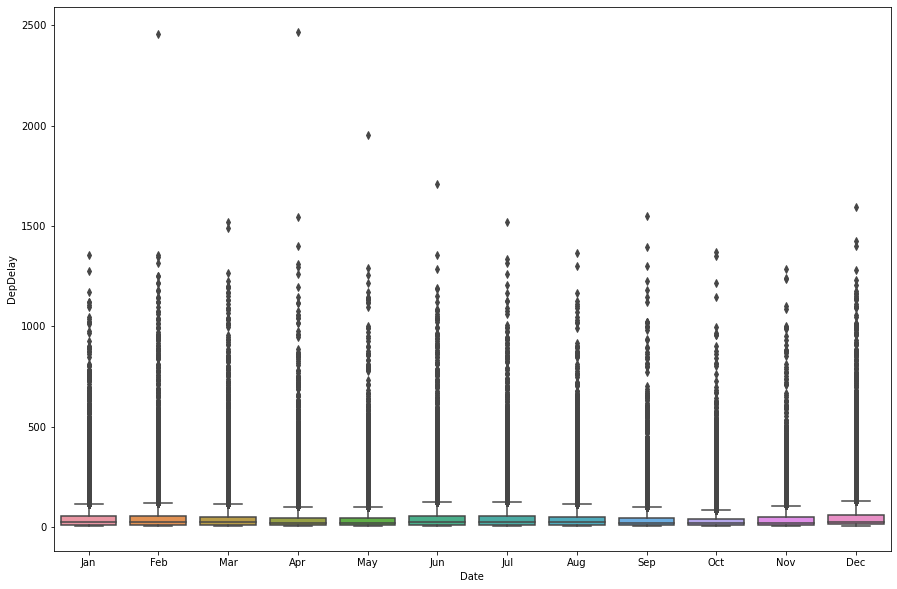

In [63]:
month = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
fig = plt.subplots(figsize=(15, 10))

moths = df["Date"].dt.month

fig = sns.boxplot(x = moths , y=df["DepDelay"])
fig.set_xticklabels(month)
plt.show()

The boxplot shows that there are many outtliers values,on the positive side are the delayed values and we can see that are many and in incremental. The negative side are the less values. The mean of the ArrDelay is moving but are similar in every month. 

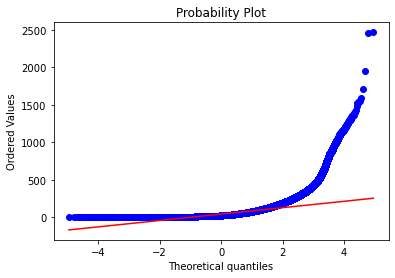

In [64]:
stats.probplot(df["DepDelay"],plot=plt)
plt.show()

The QQplot suggest that the data distribution is not normal and is skewed as we can saw the dataset have many outliers.

<h3>Correlation and Multicollinearity </h3>

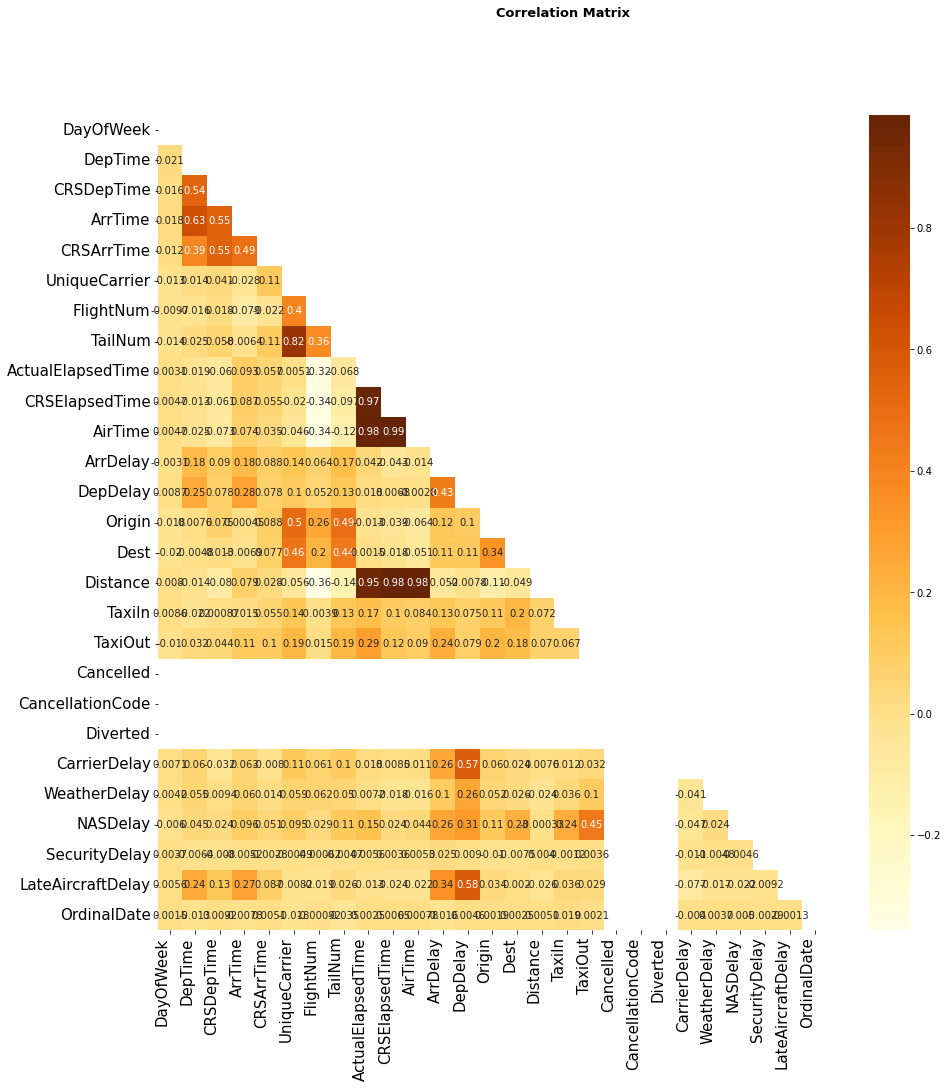

In [65]:
#Use function (6) to plot the correlation matrix
matrix_plot(df,"Correlation Matrix")

The correlation matrix show that DepDelay have more weight to the ArrDelay. 

In [66]:
#Select the numeric values 
z = df.select_dtypes(include = [np.number])
z.head().T 

,0,1,2,3,4
DayOfWeek,4.000000,4.000000,4.000000,4.000000,4.000000
DepTime,0.671571,0.560784,0.415133,0.696876,0.733678
CRSDepTime,0.676369,0.582751,0.547200,0.657786,0.680284
ArrTime,0.709720,0.524862,0.432039,0.648252,0.714117
CRSArrTime,0.672420,0.587443,0.577914,0.631712,0.671165
UniqueCarrier,0.522125,0.522125,0.522125,0.522125,0.522125
FlightNum,335.000000,3231.000000,448.000000,3920.000000,378.000000
TailNum,0.523438,0.486025,0.505843,0.571835,0.523292
ActualElapsedTime,128.000000,128.000000,96.000000,90.000000,101.000000
CRSElapsedTime,150.000000,145.000000,90.000000,90.000000,115.000000


In [67]:
#run the function (7) to get the Variance Inflation Factor(VIF)
vif(z)

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,feature,Variance Inflation Factor(VIF)
0,DayOfWeek,1.001669e+00
1,DepTime,1.896807e+00
2,CRSDepTime,1.886334e+00
3,ArrTime,2.161968e+00
4,CRSArrTime,1.596426e+00
5,UniqueCarrier,3.507218e+00
6,FlightNum,1.390677e+00
7,TailNum,3.247991e+00
8,ActualElapsedTime,inf
9,CRSElapsedTime,2.566946e+02


The multicollinearity are the correlation of the independent variables I wil drop the variables with more than a VIF of 5 but with the exepcion of the important variables to predict the ArrDelay.   

In [68]:
#copy of the DF before drop features in case of use
df_copy = df.copy()

In [69]:
#drop the features with high dependency
df.drop(columns=["CRSDepTime","ActualElapsedTime","CRSElapsedTime","AirTime",
                 "Distance","CarrierDelay","TaxiIn","Cancelled","CancellationCode",
                "Diverted","CarrierDelay","WeatherDelay","NASDelay",
                "SecurityDelay","LateAircraftDelay","Date"],inplace=True)

In [70]:
#Select the numeric values 
z = df.select_dtypes(include = [np.number])
z.head().T 

,0,1,2,3,4
DayOfWeek,4.000000,4.000000,4.000000,4.000000,4.000000
DepTime,0.671571,0.560784,0.415133,0.696876,0.733678
ArrTime,0.709720,0.524862,0.432039,0.648252,0.714117
CRSArrTime,0.672420,0.587443,0.577914,0.631712,0.671165
UniqueCarrier,0.522125,0.522125,0.522125,0.522125,0.522125
FlightNum,335.000000,3231.000000,448.000000,3920.000000,378.000000
TailNum,0.523438,0.486025,0.505843,0.571835,0.523292
ArrDelay,0.000000,0.000000,0.000000,1.000000,0.000000
DepDelay,8.000000,19.000000,8.000000,34.000000,25.000000
Origin,0.691697,0.691697,0.654880,0.654880,0.654880


In [71]:
#run the function (7) to get the Variance Inflation Factor(VIF)
vif(z)

,feature,Variance Inflation Factor(VIF)
0,DayOfWeek,1.001171
1,DepTime,1.738213
2,ArrTime,2.000441
3,CRSArrTime,1.380661
4,UniqueCarrier,3.355531
5,FlightNum,1.217455
6,TailNum,3.179920
7,ArrDelay,1.316773
8,DepDelay,1.334533
9,Origin,1.422497


In [72]:
#Select the numeric values 
z = df.select_dtypes(include = [np.number])
z.head().T 

,0,1,2,3,4
DayOfWeek,4.000000,4.000000,4.000000,4.000000,4.000000
DepTime,0.671571,0.560784,0.415133,0.696876,0.733678
ArrTime,0.709720,0.524862,0.432039,0.648252,0.714117
CRSArrTime,0.672420,0.587443,0.577914,0.631712,0.671165
UniqueCarrier,0.522125,0.522125,0.522125,0.522125,0.522125
FlightNum,335.000000,3231.000000,448.000000,3920.000000,378.000000
TailNum,0.523438,0.486025,0.505843,0.571835,0.523292
ArrDelay,0.000000,0.000000,0.000000,1.000000,0.000000
DepDelay,8.000000,19.000000,8.000000,34.000000,25.000000
Origin,0.691697,0.691697,0.654880,0.654880,0.654880


In [73]:
#run the function (7) to get the Variance Inflation Factor(VIF)
vif(z)

,feature,Variance Inflation Factor(VIF)
0,DayOfWeek,1.001171
1,DepTime,1.738213
2,ArrTime,2.000441
3,CRSArrTime,1.380661
4,UniqueCarrier,3.355531
5,FlightNum,1.217455
6,TailNum,3.179920
7,ArrDelay,1.316773
8,DepDelay,1.334533
9,Origin,1.422497


In [74]:
df.drop(columns=["OrdinalDate"],inplace=True)

In [75]:
#Select the numeric values 
z = df.select_dtypes(include = [np.number])
z.head().T 

,0,1,2,3,4
DayOfWeek,4.000000,4.000000,4.000000,4.000000,4.000000
DepTime,0.671571,0.560784,0.415133,0.696876,0.733678
ArrTime,0.709720,0.524862,0.432039,0.648252,0.714117
CRSArrTime,0.672420,0.587443,0.577914,0.631712,0.671165
UniqueCarrier,0.522125,0.522125,0.522125,0.522125,0.522125
FlightNum,335.000000,3231.000000,448.000000,3920.000000,378.000000
TailNum,0.523438,0.486025,0.505843,0.571835,0.523292
ArrDelay,0.000000,0.000000,0.000000,1.000000,0.000000
DepDelay,8.000000,19.000000,8.000000,34.000000,25.000000
Origin,0.691697,0.691697,0.654880,0.654880,0.654880


In [76]:
#run the function (7) to get the Variance Inflation Factor(VIF)
vif(z)

,feature,Variance Inflation Factor(VIF)
0,DayOfWeek,4.939323
1,DepTime,93.458431
2,ArrTime,104.562752
3,CRSArrTime,220.123273
4,UniqueCarrier,302.076047
5,FlightNum,2.708893
6,TailNum,194.956433
7,ArrDelay,3.557819
8,DepDelay,2.187897
9,Origin,143.995377


In [77]:
df.drop(columns=["DepTime","ArrTime","CRSArrTime","UniqueCarrier",
                 "TailNum","Dest","Origin","Dest"],inplace=True)

In [78]:
#Select the numeric values 
z = df.select_dtypes(include = [np.number])
z.head().T 

,0,1,2,3,4
DayOfWeek,4,4,4,4,4
FlightNum,335,3231,448,3920,378
ArrDelay,0,0,0,1,0
DepDelay,8,19,8,34,25
TaxiOut,8,10,17,10,10


In [79]:
#run the function (7) to get the Variance Inflation Factor(VIF)
vif(z)

,feature,Variance Inflation Factor(VIF)
0,DayOfWeek,2.710959
1,FlightNum,1.990138
2,ArrDelay,3.278851
3,DepDelay,2.027521
4,TaxiOut,2.452959


<h2> Level 1</h2>

<h3> Exercise 1 </h3>

**Create at least three different classification models to try to best predict DelayedFlights.csv flight delay (ArrDelay). Consider whether the flight is late or not (ArrDelay> 0).**

<h4> Sampling </h4>

In [80]:
#obtain the sample size
population = df.shape[0]
sample_size = round(population/(1+population*(.05**2)))
sample_size

400

The size of the population is to large it will be 400 samples with this formula, I will take the 1% of all the size as a sample size. **The decision to take this percent is the poor performace of my computer when the K-Nearest Neighbors runs with a bigger sample.**        

In [81]:
#new sample size
sample_size = round(df.shape[0]*.01)
sample_size

19284

In [82]:
#sample of the DF
df_sample = df.sample(n = sample_size, random_state=7)
df_sample.head().T

,259237,439183,1505172,1555433,23143
DayOfWeek,6,3,5,3,5
FlightNum,540,5461,791,6578,2092
ArrDelay,0,0,1,0,0
DepDelay,10,15,73,18,14
TaxiOut,17,16,16,14,9


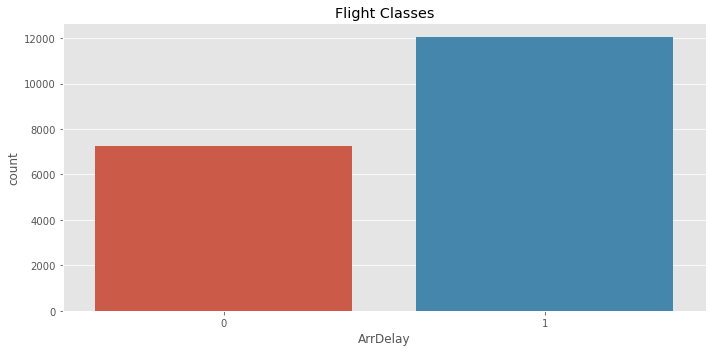

In [83]:
plt.figure(figsize=(10,5))
plt.style.use('ggplot')
sns.countplot(x="ArrDelay",data=df_sample) 
plt.title("Flight Classes")
plt.tight_layout()
plt.show()

In [84]:
X= df_sample.drop(["ArrDelay"], axis=1)
y = df_sample["ArrDelay"]
X.head()

,DayOfWeek,FlightNum,DepDelay,TaxiOut
259237,6,540,10,17
439183,3,5461,15,16
1505172,5,791,73,16
1555433,3,6578,18,14
23143,5,2092,14,9


In [85]:
over = SMOTE(sampling_strategy='not majority')
under = RandomUnderSampler(sampling_strategy='not majority')
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_smru,y_smru = pipeline.fit_resample(X,y)

**The decision to make a comparison is to know the differences between the two types of sampling** 

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


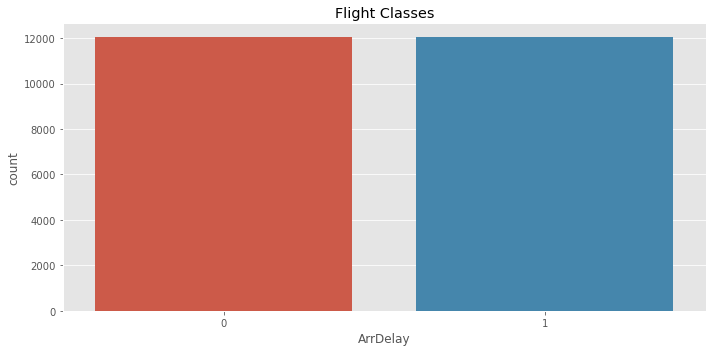

In [86]:
plt.figure(figsize=(10,5))
plt.style.use('ggplot')
sns.countplot(y_smru) 
plt.title("Flight Classes")
plt.tight_layout()
plt.show()

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


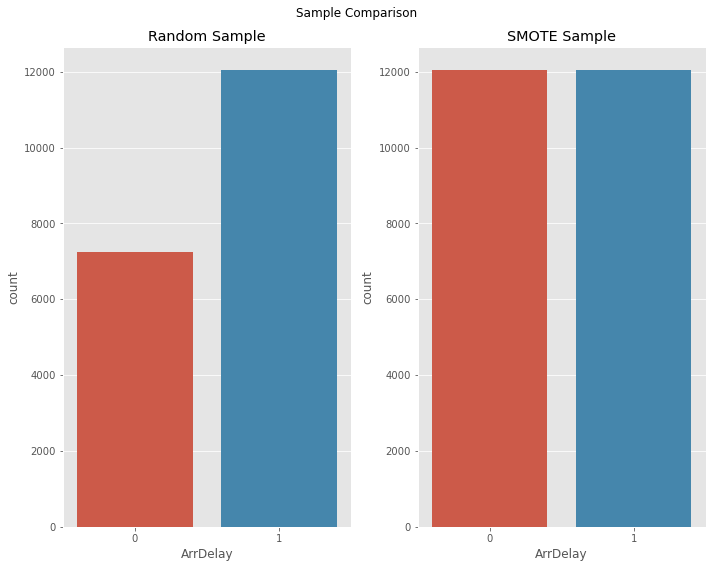

In [87]:
 #plot the Random Sampling vs SMOTE 

fig , axes = plt.subplots(1,2,figsize=(10,8))
    
fig =sns.countplot(x="ArrDelay",data=df_sample,
                  label= "Train-Test" , ax=axes[0])
fig = sns.countplot(y_smru , ax=axes[1])
    
axes[0].set_title("Random Sample")
axes[1].set_title("SMOTE Sample")

plt.suptitle("Sample Comparison")
plt.tight_layout()
plt.show()

<h4>Split Data</h4>

In [88]:
#Split set 
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X, y.values.reshape(-1,1),
                                                    test_size= 0.20, random_state=17,  
                                                    shuffle = True)

In [89]:
 #Split set 
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_smru,y_smru.values.reshape(-1,1),
                                                    test_size= 0.20, random_state=17,  
                                                    shuffle = True)

<h4> Model 1: Logistic Regression</h4>

<h5> Model 1: Logistic Regression Random Sample</h5>

In [90]:
mod1_rs = LogisticRegression()
mod1_rs.fit(X_train_rs,y_train_rs)
y_pred1_rs = mod1_rs.predict(X_test_rs)

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [91]:
#Confusion matrix
conf_matrix_mod1_rs = confusion_matrix(y_test_rs, y_pred1_rs)
#Accuracy
acu_mod1_rs = accuracy_score(y_test_rs, y_pred1_rs)
#AUC 
auc_mod1_rs = roc_auc_score(y_test_rs, y_pred1_rs)

In [92]:
report_mod1_rs = classification_report(y_test_rs, y_pred1_rs,output_dict=True)
df_report_mod1_rs = pd.DataFrame(report_mod1_rs).T
df_report_mod1_rs

,precision,recall,f1-score,support
0,0.794922,0.853249,0.823054,1431.000000
1,0.909522,0.870157,0.889404,2426.000000
accuracy,0.863884,0.863884,0.863884,0.863884
macro avg,0.852222,0.861703,0.856229,3857.000000
weighted avg,0.867004,0.863884,0.864787,3857.000000


  <h5> Model 1: Logistic Regression SMOTE</h5>


In [93]:
mod1_sm = LogisticRegression()
mod1_sm.fit(X_train_sm,y_train_sm)
y_pred1_sm = mod1_sm.predict(X_test_sm)

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [94]:
#Confusion matrix
conf_matrix_mod1_sm = confusion_matrix(y_test_sm, y_pred1_sm)
#Accuracy
acu_mod1_sm = accuracy_score(y_test_sm, y_pred1_sm)
#AUC
auc_mod1_sm = roc_auc_score(y_test_sm, y_pred1_sm)

In [95]:
report_mod1_sm = classification_report(y_test_sm, y_pred1_sm,output_dict=True)
df_report_mod1_sm = pd.DataFrame(report_mod1_sm).T
df_report_mod1_sm

,precision,recall,f1-score,support
0,0.862888,0.912146,0.886833,2470.000000
1,0.901721,0.847595,0.873820,2349.000000
accuracy,0.880681,0.880681,0.880681,0.880681
macro avg,0.882304,0.879870,0.880327,4819.000000
weighted avg,0.881817,0.880681,0.880490,4819.000000


<h4> Model 2: Support Vector Machine Classifier (SVMC)</h4>

<h5> Model 2: SVMC Random Sample</h5>

In [96]:
mod2_rs = svm.SVC(probability=True)
mod2_rs.fit(X_train_rs,y_train_rs)
y_pred2_rs = mod2_rs.predict(X_test_rs)

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [97]:
#Confusion matrix
conf_matrix_mod2_rs = confusion_matrix(y_test_rs, y_pred2_rs)
#Accuracy
acu_mod2_rs = accuracy_score(y_test_rs, y_pred2_rs)
#AUC
auc_mod2_rs = roc_auc_score(y_test_rs, y_pred2_rs)

In [98]:
report_mod2_rs = classification_report(y_test_rs, y_pred2_rs,output_dict=True)
df_report_mod2_rs = pd.DataFrame(report_mod2_rs).T
df_report_mod2_rs

,precision,recall,f1-score,support
0,0.962500,0.053809,0.101919,1431.000000
1,0.641514,0.998763,0.781235,2426.000000
accuracy,0.648172,0.648172,0.648172,0.648172
macro avg,0.802007,0.526286,0.441577,3857.000000
weighted avg,0.760604,0.648172,0.529199,3857.000000


<h5> Model 2: SVMC SMOTE</h5>

In [99]:
mod2_sm = svm.SVC(probability=True)
mod2_sm.fit(X_train_sm,y_train_sm)
y_pred2_sm = mod2_sm.predict(X_test_sm)

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [100]:
#Confusion matrix
conf_matrix_mod2_sm = confusion_matrix(y_test_sm, y_pred2_sm)
#Accuracy
acu_mod2_sm = accuracy_score(y_test_sm, y_pred2_sm)
#AUC
auc_mod2_sm = roc_auc_score(y_test_sm, y_pred2_sm)

In [101]:
report_mod2_sm = classification_report(y_test_sm, y_pred2_sm,output_dict=True)
df_report_mod2_sm = pd.DataFrame(report_mod2_sm).T
df_report_mod2_sm

,precision,recall,f1-score,support
0,0.691795,0.965992,0.806217,2470.000000
1,0.938686,0.547467,0.691584,2349.000000
accuracy,0.761984,0.761984,0.761984,0.761984
macro avg,0.815240,0.756729,0.748901,4819.000000
weighted avg,0.812141,0.761984,0.750340,4819.000000


<h4> Model 3: K-Nearest Neighbors Classifier (KNNC)</h4>

<h5> Model 3: KNNC Random Sample</h5>

In [102]:
mod3_rs = KNeighborsClassifier()
mod3_rs.fit(X_train_rs,y_train_rs)
y_pred3_rs = mod3_rs.predict(X_test_rs)

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [103]:
#Confusion matrix
conf_matrix_mod3_rs = confusion_matrix(y_test_rs, y_pred3_rs)
#Accuracy
acu_mod3_rs = accuracy_score(y_test_rs, y_pred3_rs)
#AUC
auc_mod3_rs = roc_auc_score(y_test_rs, y_pred3_rs)

In [104]:
report_mod3_rs = classification_report(y_test_rs, y_pred3_rs,output_dict=True)
df_report_mod3_rs = pd.DataFrame(report_mod3_rs).T
df_report_mod3_rs

,precision,recall,f1-score,support
0,0.768182,0.826695,0.796365,1431.000000
1,0.892965,0.852844,0.872444,2426.000000
accuracy,0.843142,0.843142,0.843142,0.843142
macro avg,0.830573,0.839769,0.834404,3857.000000
weighted avg,0.846669,0.843142,0.844217,3857.000000


<h5> Model 3: KNNC SMOTE</h5>

In [105]:
mod3_sm = KNeighborsClassifier()
mod3_sm.fit(X_train_sm,y_train_sm)
y_pred3_sm = mod3_sm.predict(X_test_sm)

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [106]:
#Confusion matrix
conf_matrix_mod3_sm = confusion_matrix(y_test_sm, y_pred3_sm)
#Accuracy
acu_mod3_sm = accuracy_score(y_test_sm, y_pred3_sm)
#AUC
auc_mod3_sm = roc_auc_score(y_test_sm, y_pred3_sm)

In [107]:
report_mod3_sm = classification_report(y_test_sm, y_pred3_sm,output_dict=True)
df_report_mod3_sm = pd.DataFrame(report_mod3_sm).T
df_report_mod3_sm 

,precision,recall,f1-score,support
0,0.843311,0.923887,0.881762,2470.000000
1,0.911027,0.819498,0.862842,2349.000000
accuracy,0.873003,0.873003,0.873003,0.873003
macro avg,0.877169,0.871692,0.872302,4819.000000
weighted avg,0.876319,0.873003,0.872539,4819.000000


<h4> Model 4: Decision Tree Classifier (DTC)</h4>

<h5> Model 4: DT Random Sample</h5>

In [108]:
mod4_rs = DecisionTreeClassifier()
mod4_rs.fit(X_train_rs,y_train_rs)
y_pred4_rs = mod4_rs.predict(X_test_rs)

In [109]:
#Confusion matrix
conf_matrix_mod4_rs = confusion_matrix(y_test_rs, y_pred4_rs)
#Accuracy
acu_mod4_rs = accuracy_score(y_test_rs, y_pred4_rs)
#AUC
auc_mod4_rs = roc_auc_score(y_test_rs, y_pred4_rs)

In [110]:
report_mod4_rs = classification_report(y_test_rs, y_pred4_rs,output_dict=True)
df_report_mod4_rs = pd.DataFrame(report_mod4_rs).T
df_report_mod4_rs

,precision,recall,f1-score,support
0,0.735254,0.749126,0.742125,1431.000000
1,0.850354,0.840890,0.845596,2426.000000
accuracy,0.806845,0.806845,0.806845,0.806845
macro avg,0.792804,0.795008,0.793861,3857.000000
weighted avg,0.807650,0.806845,0.807207,3857.000000


<h5> Model 4: DT SMOTE</h5>

In [111]:
mod4_sm = DecisionTreeClassifier()
mod4_sm.fit(X_train_sm,y_train_sm)
y_pred4_sm = mod4_sm.predict(X_test_sm)

In [112]:
#Confusion matrix
conf_matrix_mod4_sm = confusion_matrix(y_test_sm, y_pred4_sm)
#Accuracy
acu_mod4_sm = accuracy_score(y_test_sm, y_pred4_sm)
#AUC
auc_mod4_sm = roc_auc_score(y_test_sm, y_pred4_sm)

In [113]:
report_mod4_sm = classification_report(y_test_sm, y_pred4_sm,output_dict=True)
df_report_mod4_sm = pd.DataFrame(report_mod4_sm).T
df_report_mod4_sm

,precision,recall,f1-score,support
0,0.848894,0.839271,0.844055,2470.000000
1,0.832983,0.842912,0.837918,2349.000000
accuracy,0.841046,0.841046,0.841046,0.841046
macro avg,0.840939,0.841092,0.840987,4819.000000
weighted avg,0.841138,0.841046,0.841064,4819.000000


<h3> Exercise 2 </h3>

**Compare classification models using accuracy, a confidence matrix, and other more advanced metrics.**

<h4> Accuracy </h4>

In [114]:
acmod_rs = {"LR":round(acu_mod1_rs,4),
          "SVMC":round(acu_mod2_rs,4),"KNNC":round(acu_mod3_rs,4),
            "DTC":round(acu_mod4_rs,4)}

In [115]:
acmod_sm = {"LR":round(acu_mod1_sm,4),
          "SVMC":round(acu_mod2_sm,4),"KNNC":round(acu_mod3_sm,4),
           "DTC":round(acu_mod4_sm,4)}

In [116]:
aucmod_rs = {"LR":round(auc_mod1_rs,4),
          "SVMC":round(auc_mod2_rs,4),"KNNC":round(auc_mod3_rs,4),
            "DTC":round(auc_mod4_rs,4)}

In [117]:
aucmod_sm = {"LR":round(auc_mod1_sm,4),
          "SVMC":round(auc_mod2_sm,4),"KNNC":round(auc_mod3_sm,4),
            "DTC":round(acu_mod4_sm,4)}

In [118]:
metrics_df= pd.DataFrame([acmod_rs,acmod_sm],
                          index=["Accuracy RS","Accuracy SM"]).T 
(metrics_df)*100

,Accuracy RS,Accuracy SM
LR,86.39,88.07
SVMC,64.82,76.20
KNNC,84.31,87.30
DTC,80.68,84.10


The Logistic Regression have the best accuracy scores and have similars results in a balanced and unbalanced sample. The models have a better performace with the balanced sample (SMOTE) so is important to check the class imbalance.    

<h4> ROC and Confusion Matrix </h4>

The sample are now balanced so the ROC is a good metric.

<h5> Logistic Regression </h5>

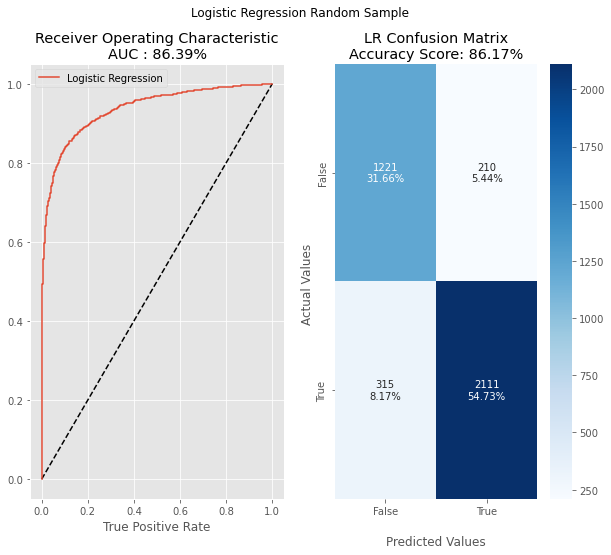

In [119]:
#run the functiona (9)
subplots_ROC_CM("Logistic Regression Random Sample","Receiver Operating Characteristic",
                "LR Confusion Matrix",
                mod1_rs,acmod_rs,aucmod_rs,conf_matrix_mod1_rs,"LR",X_test_rs,y_test_rs) 

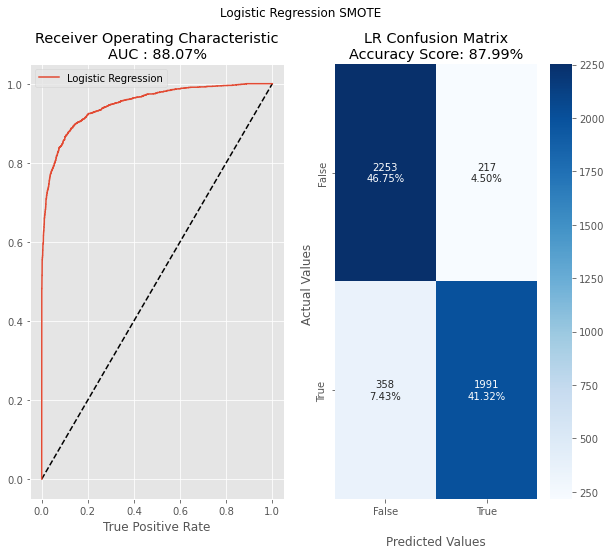

In [120]:
#run the functiona (9)
subplots_ROC_CM("Logistic Regression SMOTE","Receiver Operating Characteristic",
                "LR Confusion Matrix",
                mod1_sm,acmod_sm,aucmod_sm,conf_matrix_mod1_sm,"LR",X_test_sm,y_test_sm) 

<h5> Support Vector Machine Classifier </h5>

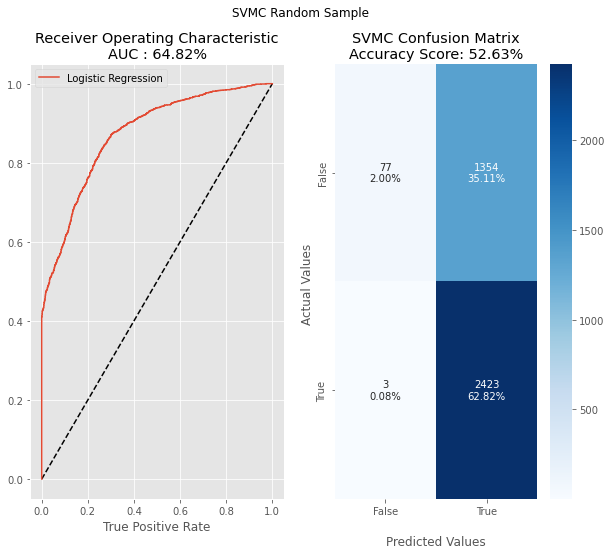

In [121]:
#run the functiona (9)
subplots_ROC_CM("SVMC Random Sample","Receiver Operating Characteristic",
                "SVMC Confusion Matrix",
                mod2_rs,acmod_rs,aucmod_rs,conf_matrix_mod2_rs,"SVMC",X_test_rs,y_test_rs) 

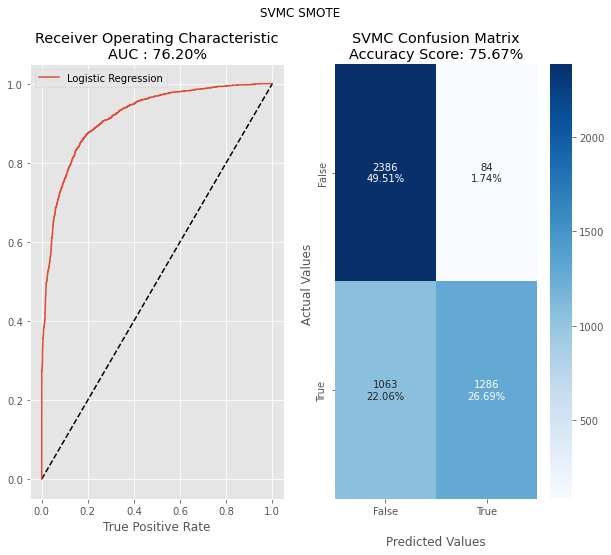

In [122]:
#run the functiona (9)
subplots_ROC_CM("SVMC SMOTE","Receiver Operating Characteristic",
                "SVMC Confusion Matrix",
                mod2_sm,acmod_sm,aucmod_sm,conf_matrix_mod2_sm,"SVMC",X_test_sm,y_test_sm) 

<h5> K-Nearest Neighbors Classifier </h5>

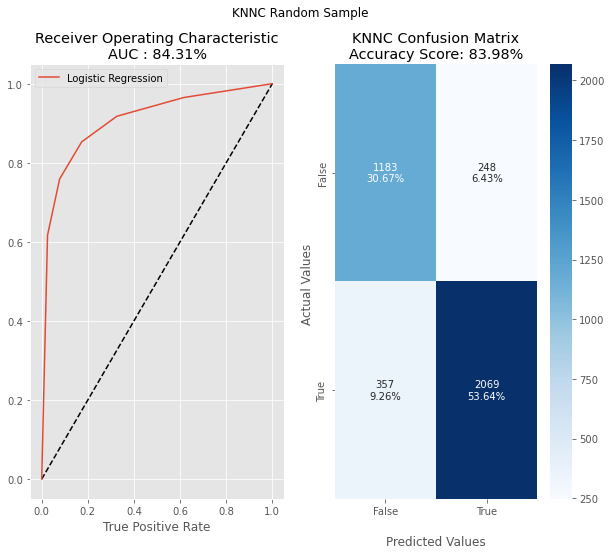

In [123]:
#run the functiona (9)
subplots_ROC_CM("KNNC Random Sample","Receiver Operating Characteristic",
                "KNNC Confusion Matrix",
                mod3_rs,acmod_rs,aucmod_rs,conf_matrix_mod3_rs,"KNNC",X_test_rs,y_test_rs) 

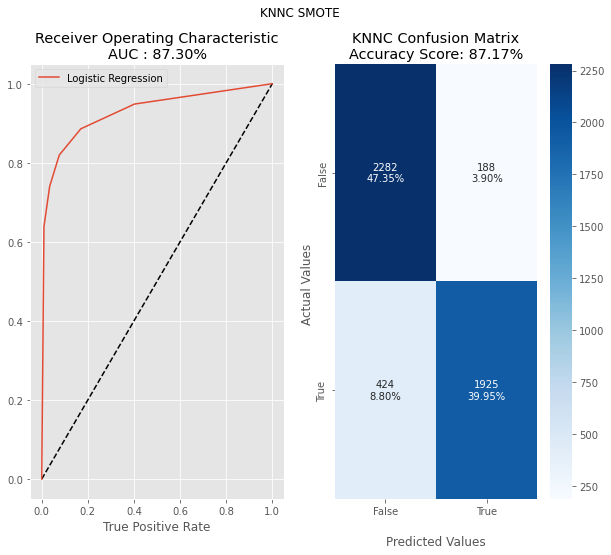

In [124]:
#run the functiona (9)
subplots_ROC_CM("KNNC SMOTE","Receiver Operating Characteristic",
                "KNNC Confusion Matrix",
                mod3_sm,acmod_sm,aucmod_sm,conf_matrix_mod3_sm,"KNNC",X_test_sm,y_test_sm) 

<h5> Decision Tree Classifier </h5>

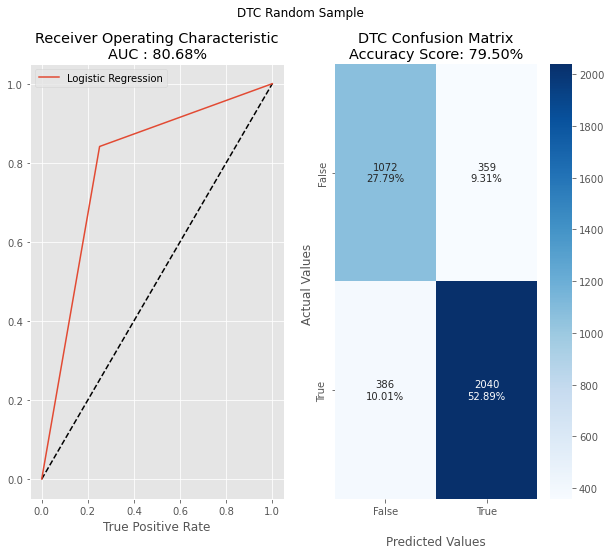

In [125]:
#run the functiona (9)
subplots_ROC_CM("DTC Random Sample","Receiver Operating Characteristic",
                "DTC Confusion Matrix",
                mod4_rs,acmod_rs,aucmod_rs,conf_matrix_mod4_rs,"DTC",X_test_rs,y_test_rs) 

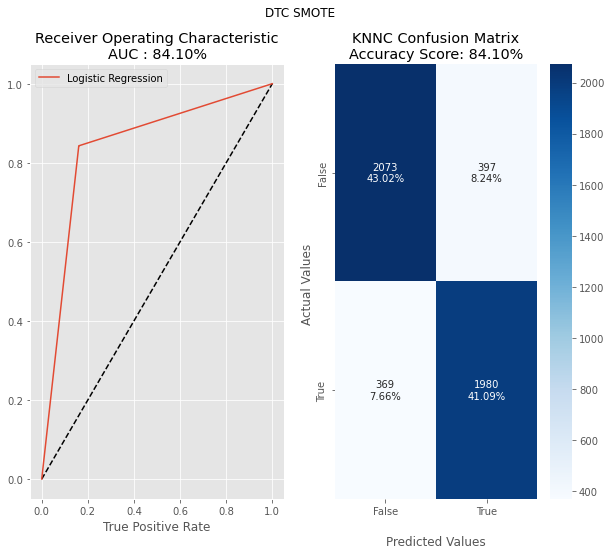

In [126]:
#run the functiona (9)
subplots_ROC_CM("DTC SMOTE","Receiver Operating Characteristic",
                "KNNC Confusion Matrix",
                mod4_sm,acmod_sm,aucmod_sm,conf_matrix_mod4_sm,"DTC",X_test_sm,y_test_sm) 

In [127]:
TN1_rs = conf_matrix_mod1_rs[0,0]
FP1_rs = conf_matrix_mod1_rs[0,1]
FN1_rs = conf_matrix_mod1_rs[1,0]
TP1_rs = conf_matrix_mod1_rs[1,1]

TN2_rs = conf_matrix_mod2_rs[0,0]
FP2_rs = conf_matrix_mod2_rs[0,1]
FN2_rs = conf_matrix_mod2_rs[1,0]
TP2_rs = conf_matrix_mod2_rs[1,1]

TN3_rs = conf_matrix_mod3_rs[0,0]
FP3_rs = conf_matrix_mod3_rs[0,1]
FN3_rs = conf_matrix_mod3_rs[1,0]
TP3_rs = conf_matrix_mod3_rs[1,1]

TN4_rs = conf_matrix_mod4_rs[0,0]
FP4_rs = conf_matrix_mod4_rs[0,1]
FN4_rs = conf_matrix_mod4_rs[1,0]
TP4_rs = conf_matrix_mod4_rs[1,1]

In [128]:
TN1_sm = conf_matrix_mod1_sm[0,0]
FP1_sm = conf_matrix_mod1_sm[0,1]
FN1_sm = conf_matrix_mod1_sm[1,0]
TP1_sm = conf_matrix_mod1_sm[1,1]

TN2_sm = conf_matrix_mod2_sm[0,0]
FP2_sm = conf_matrix_mod2_sm[0,1]
FN2_sm = conf_matrix_mod2_sm[1,0]
TP2_sm = conf_matrix_mod2_sm[1,1]

TN3_sm = conf_matrix_mod3_sm[0,0]
FP3_sm = conf_matrix_mod3_sm[0,1]
FN3_sm = conf_matrix_mod3_sm[1,0]
TP3_sm = conf_matrix_mod3_sm[1,1]

TN4_sm = conf_matrix_mod4_sm[0,0]
FP4_sm = conf_matrix_mod4_sm[0,1]
FN4_sm = conf_matrix_mod4_sm[1,0]
TP4_sm = conf_matrix_mod4_sm[1,1]

In [129]:
TN = [[TN1_sm,TN2_sm,TN3_sm,TN4_sm],[TN1_rs,TN2_rs,TN3_rs,TN4_rs]]

In [130]:
FP = [FP1_rs, FP2_rs, FP3_rs, FP4_rs],[FP1_sm, FP2_sm,FP3_sm, FP4_sm]

In [131]:
FN = [[FN1_rs,FN2_rs,FN3_rs,FN4_rs],[FN1_sm,FN2_sm,FN3_sm,FN4_sm]]

In [132]:
TP = [TP1_rs,TP2_rs,TP3_rs,TP4_rs],[TP1_sm,TP2_sm,TP3_sm,TP4_sm]

In [133]:
TN_df = pd.DataFrame(TN).T
FP_df = pd.DataFrame(FP).T
FN_df = pd.DataFrame(FN).T
TP_df = pd.DataFrame(TP).T

TN_df.rename(columns={0:"TN_RS",1:"TN_SM"},inplace=True)
FP_df.rename(columns={0:"FP_RS",1:"FP_SM"},inplace=True)
FN_df.rename(columns={0:"FN_RS",1:"FN_SM"},inplace=True)
TP_df.rename(columns={0:"TP_RS",1:"TP_SM"},inplace=True)

In [134]:
models = ["LR","SVMC","KNNC","DTC"]
for i,j in zip(range(4),models):
    TN_df.rename(index={i:j},inplace=True)
    FP_df.rename(index={i:j},inplace=True)
    FN_df.rename(index={i:j},inplace=True)
    TP_df.rename(index={i:j},inplace=True)

In [135]:
matrix_models = pd.concat([TN_df,FP_df,FN_df,TP_df],axis=1)
matrix_models

,TN_RS,TN_SM,FP_RS,FP_SM,FN_RS,FN_SM,TP_RS,TP_SM
LR,2253,1221,210,217,315,358,2111,1991
SVMC,2386,77,1354,84,3,1063,2423,1286
KNNC,2282,1183,248,188,357,424,2069,1925
DTC,2073,1072,359,397,386,369,2040,1980


In [136]:
scaler = StandardScaler()
scaledMetrics_models = pd.DataFrame(scaler.fit_transform(matrix_models),
                                    index = models
                                    , columns=matrix_models.columns)

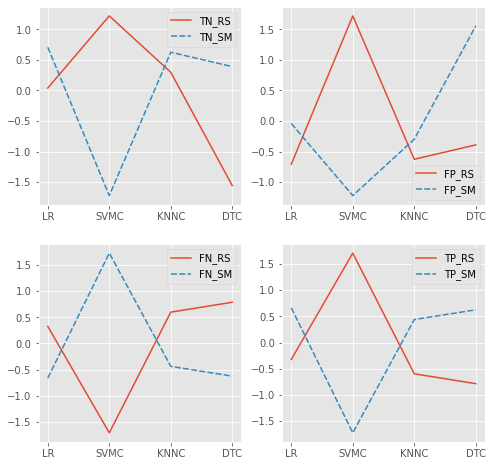

In [137]:
fig,axes = plt.subplots(2,2,figsize=(8,8))
fig = sns.lineplot(data= scaledMetrics_models[["TN_RS","TN_SM"]],ax=axes[0,0])
fig = sns.lineplot(data= scaledMetrics_models[["FP_RS","FP_SM"]],ax=axes[0,1])
fig = sns.lineplot(data= scaledMetrics_models[["FN_RS","FN_SM"]],ax=axes[1,0])
fig = sns.lineplot(data= scaledMetrics_models[["TP_RS","TP_SM"]],ax=axes[1,1])
axes[0,0].legend(labels =["TN_RS","TN_SM"],loc="best")
axes[0,1].legend(labels =["FP_RS","FP_SM"],loc="best")
axes[1,0].legend(labels =["FN_RS","FN_SM"],loc="best")
axes[1,1].legend(labels =["TP_RS","TP_SM"],loc="best")
plt.show()

The above plot show the scores of the confusion matrix, the SVMC Random Sample TN and TP behaves better. We need to consider the FP this are the predicted positive and it’s false (Type I Error) and the best model is SVMC SMOTE. The Logistic Regression have the better accuracy but it's the third better in FP the Confusion Matrix helped to see this.    

In [138]:
round(df_report_mod1_rs,4) ,round(df_report_mod1_sm,4) 

(              precision  recall  f1-score    support
 0                0.7949  0.8532    0.8231  1431.0000
 1                0.9095  0.8702    0.8894  2426.0000
 accuracy         0.8639  0.8639    0.8639     0.8639
 macro avg        0.8522  0.8617    0.8562  3857.0000
 weighted avg     0.8670  0.8639    0.8648  3857.0000,
               precision  recall  f1-score    support
 0                0.8629  0.9121    0.8868  2470.0000
 1                0.9017  0.8476    0.8738  2349.0000
 accuracy         0.8807  0.8807    0.8807     0.8807
 macro avg        0.8823  0.8799    0.8803  4819.0000
 weighted avg     0.8818  0.8807    0.8805  4819.0000)

In [139]:
round(df_report_mod2_rs,4) ,round(df_report_mod2_sm,4) 

(              precision  recall  f1-score    support
 0                0.9625  0.0538    0.1019  1431.0000
 1                0.6415  0.9988    0.7812  2426.0000
 accuracy         0.6482  0.6482    0.6482     0.6482
 macro avg        0.8020  0.5263    0.4416  3857.0000
 weighted avg     0.7606  0.6482    0.5292  3857.0000,
               precision  recall  f1-score   support
 0                0.6918  0.9660    0.8062  2470.000
 1                0.9387  0.5475    0.6916  2349.000
 accuracy         0.7620  0.7620    0.7620     0.762
 macro avg        0.8152  0.7567    0.7489  4819.000
 weighted avg     0.8121  0.7620    0.7503  4819.000)

In [140]:
round(df_report_mod3_rs,4) ,round(df_report_mod3_sm,4) 

(              precision  recall  f1-score    support
 0                0.7682  0.8267    0.7964  1431.0000
 1                0.8930  0.8528    0.8724  2426.0000
 accuracy         0.8431  0.8431    0.8431     0.8431
 macro avg        0.8306  0.8398    0.8344  3857.0000
 weighted avg     0.8467  0.8431    0.8442  3857.0000,
               precision  recall  f1-score   support
 0                0.8433  0.9239    0.8818  2470.000
 1                0.9110  0.8195    0.8628  2349.000
 accuracy         0.8730  0.8730    0.8730     0.873
 macro avg        0.8772  0.8717    0.8723  4819.000
 weighted avg     0.8763  0.8730    0.8725  4819.000)

In [141]:
round(df_report_mod4_rs,4) ,round(df_report_mod4_sm,4) 

(              precision  recall  f1-score    support
 0                0.7353  0.7491    0.7421  1431.0000
 1                0.8504  0.8409    0.8456  2426.0000
 accuracy         0.8068  0.8068    0.8068     0.8068
 macro avg        0.7928  0.7950    0.7939  3857.0000
 weighted avg     0.8077  0.8068    0.8072  3857.0000,
               precision  recall  f1-score   support
 0                0.8489  0.8393    0.8441  2470.000
 1                0.8330  0.8429    0.8379  2349.000
 accuracy         0.8410  0.8410    0.8410     0.841
 macro avg        0.8409  0.8411    0.8410  4819.000
 weighted avg     0.8411  0.8410    0.8411  4819.000)

The we can see in the classification report the mod2 SVMC has a better recall for the class 0 so this SVCM model can predict better the True Positive. 

<h3> Exercise 3 </h3>

**Train them using the different parameters they support, I will use only the SMOTE sample_.**

<h4> Model 1: Logistic Regression</h4>
 

In [142]:
#Parameters
parameters = {'penalty':["l1","l2","elasticnet"], 
              'solver':["newton-cg","lbfgs", "liblinear","sag","saga"],
              'class_weight':["balanced"]}
 
mod1_sm_p = LogisticRegression()
#instantiate the GridSearchCV object: log_grid
logR_grid_m1_sm = GridSearchCV(mod1_sm_p,parameters,scoring='roc_auc')

# Fit it to the data
logR_grid_m1_sm.fit(X_train_sm,y_train_sm)

# # Predict on the test data: y_pred
y_pred_logR_grid = logR_grid_m1_sm.predict(X_test_sm)


/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed.

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed 

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chang

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

In [143]:
#Confusion matrix
conf_matrix_mod1_log_grid_sm = confusion_matrix(y_test_sm, y_pred_logR_grid )
#Accuracy
acu_mod1_log_grid_sm = accuracy_score(y_test_sm, y_pred_logR_grid )
#AUC
auc_mod1_log_grid_sm = roc_auc_score(y_test_sm, y_pred_logR_grid )

In [144]:
print("the best parameter for the Logistic Regression are:\n {}".format(logR_grid_m1_sm.best_params_))

the best parameter for the Logistic Regression are:
 {'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [145]:
acmod_grid_sm = {"LR":round(acu_mod1_log_grid_sm,4)}
aucmod_grid_sm = {"LR":round(auc_mod1_log_grid_sm,4)}

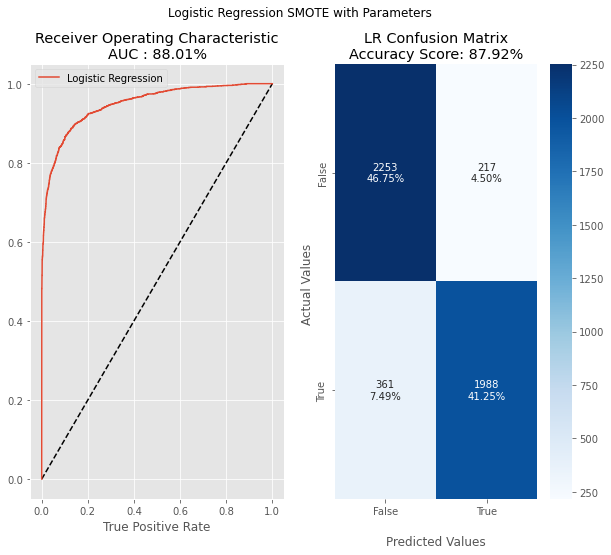

In [146]:
#run the functiona (9)
subplots_ROC_CM("Logistic Regression SMOTE with Parameters",
                "Receiver Operating Characteristic",
                "LR Confusion Matrix",
                logR_grid_m1_sm,acmod_grid_sm,aucmod_grid_sm,
                conf_matrix_mod1_log_grid_sm,"LR",X_test_sm,y_test_sm) 

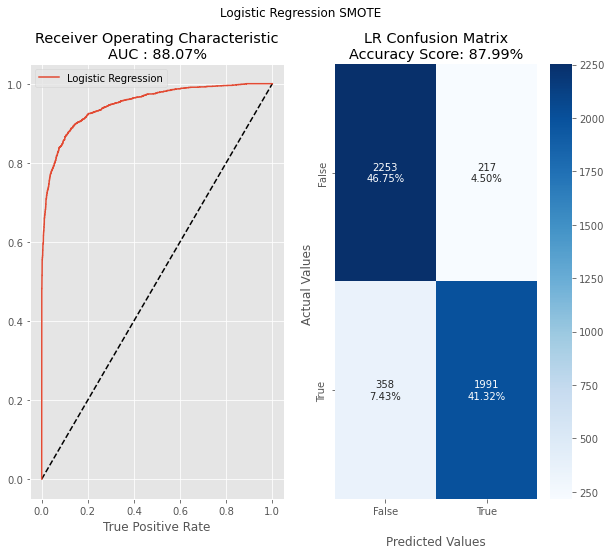

In [147]:
#run the functiona (9)
subplots_ROC_CM("Logistic Regression SMOTE","Receiver Operating Characteristic",
                "LR Confusion Matrix",
                mod1_sm,acmod_sm,aucmod_sm,conf_matrix_mod1_sm,"LR",X_test_sm,y_test_sm) 

<h4> Model 2: SVMC</h4>
 

In [148]:
#Parameters
parameters = {   
               "gamma":["scale","auto" ],
              'class_weight':["balanced"]}
 
   # model 
mod2_sm_p = svm.SVC(probability=True)
logR_grid_m2_sm = GridSearchCV(mod2_sm_p,parameters,scoring='roc_auc')
logR_grid_m2_sm.fit(X_train_sm,y_train_sm)
y_pred_logR_grid_m2 = logR_grid_m2_sm.predict(X_test_sm)
 

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed 

In [149]:
#Confusion matrix
conf_matrix_mod2_log_grid_sm = confusion_matrix(y_test_sm, y_pred_logR_grid_m2 )
#Accuracy
acu_mod2_log_grid_sm = accuracy_score(y_test_sm, y_pred_logR_grid_m2 )
#AUC
auc_mod2_log_grid_sm = roc_auc_score(y_test_sm, y_pred_logR_grid_m2 )

In [177]:
print("the best parameter for the SVMC are:\n {}".format(logR_grid_m2_sm.best_params_))

the best parameter for the SVMC are:
 {'class_weight': 'balanced', 'gamma': 'scale'}


In [183]:
acmod_grid_m2_sm = {"SVMC":round(acu_mod2_log_grid_sm,4)}
aucmod_grid_m2_sm = {"SVMC":round(auc_mod2_log_grid_sm,4)}


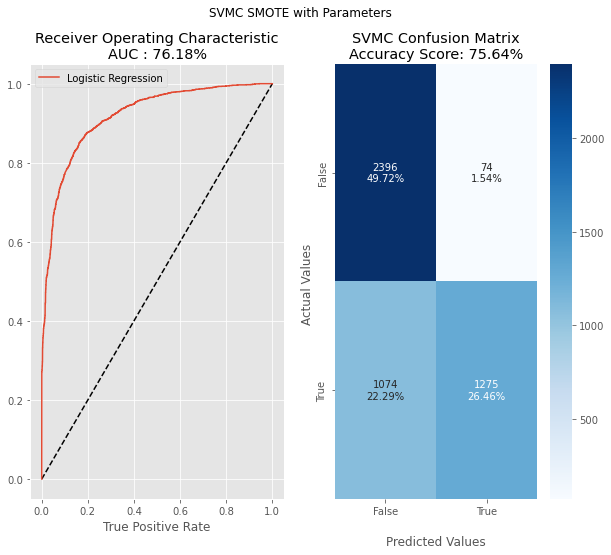

In [185]:
#run the functiona (9)
subplots_ROC_CM("SVMC SMOTE with Parameters",
                "Receiver Operating Characteristic",
                "SVMC Confusion Matrix",
                logR_grid_m2_sm,acmod_grid_m2_sm,aucmod_grid_m2_sm,
                conf_matrix_mod2_log_grid_sm,"SVMC",X_test_sm,y_test_sm) 

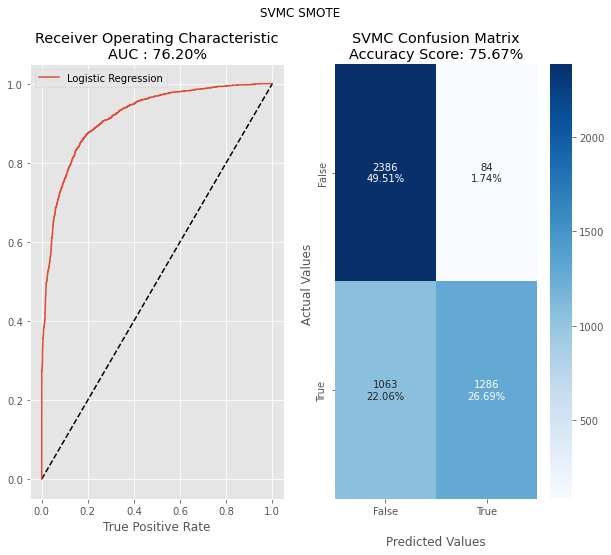

In [153]:
#run the functiona (9)
subplots_ROC_CM("SVMC SMOTE","Receiver Operating Characteristic",
                "SVMC Confusion Matrix",
                mod2_sm,acmod_sm,aucmod_sm,conf_matrix_mod2_sm,"SVMC",X_test_sm,y_test_sm) 

<h4> Model 3: KNNC</h4>
 
 
 

In [155]:
#Parameters
parameters = {"weights":[ "uniform","distance"],  
               "algorithm":["auto" ,"ball_tree", "kd_tree","brute"] }
 
   # model 
mod3_sm_p = KNeighborsClassifier()
knn_grid_m3_sm = GridSearchCV(mod3_sm_p,parameters,scoring='roc_auc')
knn_grid_m3_sm.fit(X_train_sm,y_train_sm)
y_pred_knn_grid_m3 = knn_grid_m3_sm.predict(X_test_sm)
 


/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A

In [156]:
#Confusion matrix
conf_matrix_mod3_knn_grid_sm = confusion_matrix(y_test_sm, y_pred_knn_grid_m3 )
#Accuracy
acu_mod3_knn_grid_sm = accuracy_score(y_test_sm, y_pred_knn_grid_m3 )
#AUC
auc_mod3_knn_grid_sm = roc_auc_score(y_test_sm, y_pred_knn_grid_m3 )

In [178]:
print("the best parameter for the KNNC are:\n {}".format(knn_grid_m3_sm.best_params_))

the best parameter for the KNNC are:
 {'algorithm': 'auto', 'weights': 'distance'}


In [166]:
acmod_grid_m3_sm = {"KNNC":round(acu_mod3_knn_grid_sm,4)}
aucmod_grid_m3_sm = {"KNNC":round(auc_mod3_knn_grid_sm,4)}


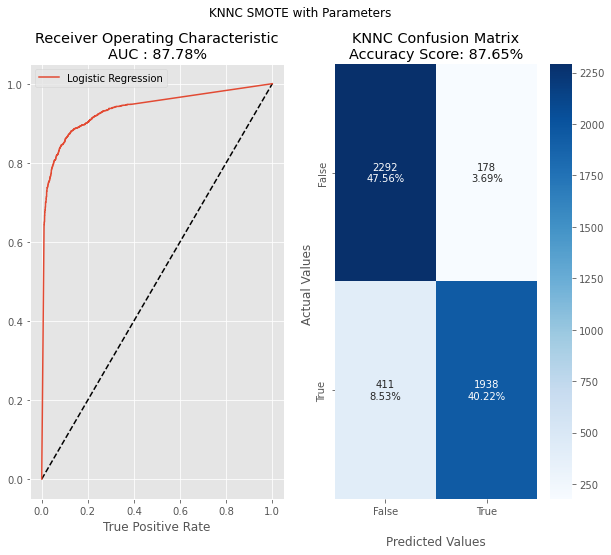

In [168]:
#run the functiona (9)
subplots_ROC_CM("KNNC SMOTE with Parameters","Receiver Operating Characteristic",
                "KNNC Confusion Matrix",
                knn_grid_m3_sm,acmod_grid_m3_sm,aucmod_grid_m3_sm,
                conf_matrix_mod3_knn_grid_sm,"KNNC",X_test_sm,y_test_sm) 

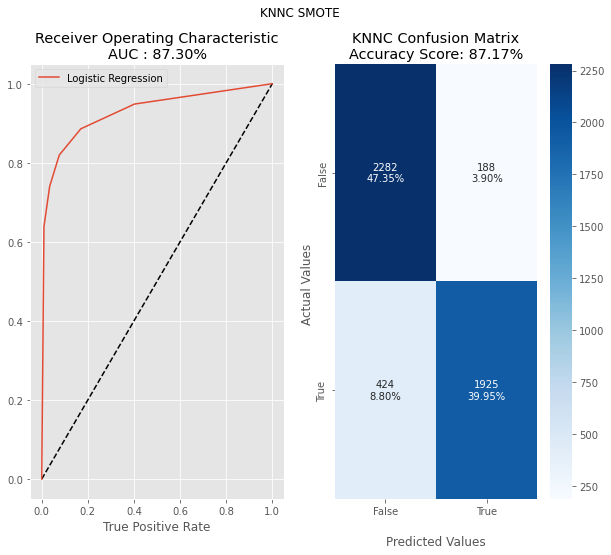

In [169]:
#run the functiona (9)
subplots_ROC_CM("KNNC SMOTE","Receiver Operating Characteristic",
                "KNNC Confusion Matrix",
                mod3_sm,acmod_sm,aucmod_sm,conf_matrix_mod3_sm,"KNNC",X_test_sm,y_test_sm) 

<h4> Model 4: DTC</h4>
 
 
 

In [172]:
 
#Parameters
parameters = {"criterion":["gini", "entropy", "log_loss"],  
               "min_samples_split":[5],
             "max_features":["auto", "sqrt", "log2"]}

mod4_sm_p = DecisionTreeClassifier()
dt_grid_m4_sm = GridSearchCV(mod4_sm_p,parameters,scoring='roc_auc')
dt_grid_m4_sm.fit(X_train_sm,y_train_sm)
y_pred_dt_grid_m4 = dt_grid_m4_sm.predict(X_test_sm)

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 348, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
KeyError: 'log_loss'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWa

In [173]:
#Confusion matrix
conf_matrix_mod4_dt_grid_sm = confusion_matrix(y_test_sm, y_pred_dt_grid_m4 )
#Accuracy
acu_mod4_dt_grid_sm = accuracy_score(y_test_sm, y_pred_dt_grid_m4 )
#AUC
auc_mod4_dt_grid_sm = roc_auc_score(y_test_sm, y_pred_dt_grid_m4 )

In [175]:
print("the best parameter for the DT are:\n {}".format(dt_grid_m4_sm.best_params_))

the best parameter for the KNNC are:
 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 5}


In [180]:
acmod_grid_m4_sm = {"DTC":round(acu_mod4_dt_grid_sm,4)}
aucmod_grid_m4_sm = {"DTC":round(auc_mod4_dt_grid_sm,4)}


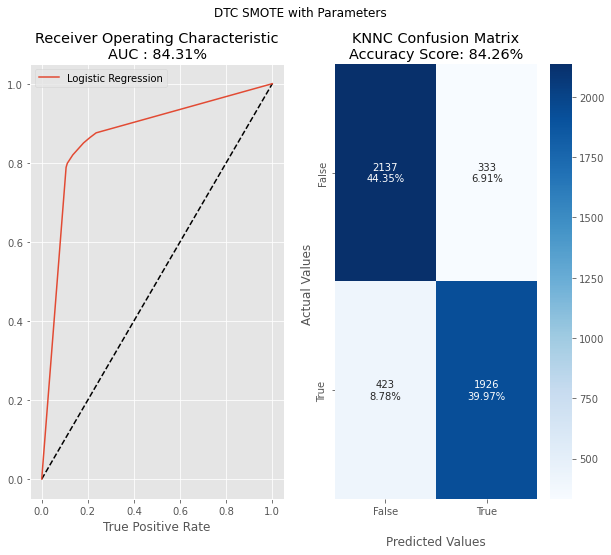

In [181]:
#run the functiona (9)
subplots_ROC_CM("DTC SMOTE with Parameters","Receiver Operating Characteristic",
                "KNNC Confusion Matrix",
                dt_grid_m4_sm,acmod_grid_m4_sm,aucmod_grid_m4_sm,
                conf_matrix_mod4_dt_grid_sm,"DTC",X_test_sm,y_test_sm) 

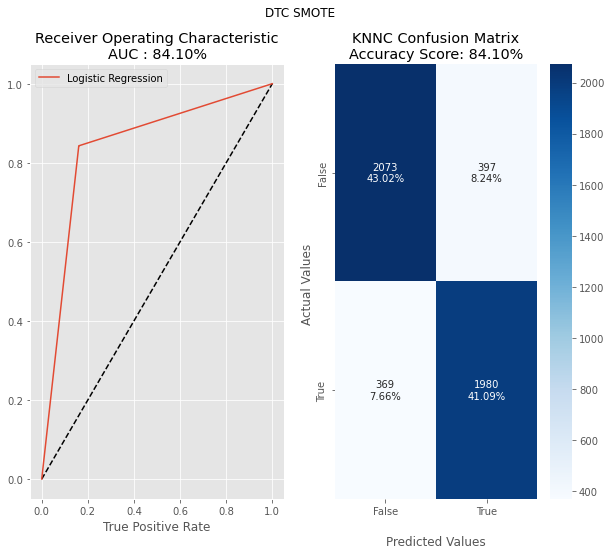

In [182]:
#run the functiona (9)
subplots_ROC_CM("DTC SMOTE","Receiver Operating Characteristic",
                "KNNC Confusion Matrix",
                mod4_sm,acmod_sm,aucmod_sm,conf_matrix_mod4_sm,"DTC",X_test_sm,y_test_sm) 

**The model with parameters have better results but  the SVMC model has a huge increase in computation time, in general with the SMOTE the increased performance is minimal but it can make a difference in some problems with sensitive performance.**  

<h3> Exercise 4 </h3>

Compare your performance using the traint / test or cross-validation approach.

<h4> Model 1: Logistic Regression </h4>

In [222]:
mod1_cv = LogisticRegression()
scores_mod1 = cross_validate(mod1_cv, X, y, cv=5,
                         scoring=('roc_auc'),
                       return_train_score=True)

/Users/franciscoregalado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [237]:
print("The AUC by train-test with smote and parameters is {}% \n and by cross-validation of the model is {}%".format(aucmod_grid_sm.get("LR")*100,
                                                                                              round(scores_mod1 ["test_score"].mean(),4)*100)) 


The AUC by train-test with smote and parameters is 87.92% 
 and by cross-validation of the model is 94.23%


<h4> Model 2: SVMC </h4>

In [223]:
mod2_cv = svm.SVC(probability=True)
scores_mod2 = cross_validate(mod2_cv, X, y, cv=5,
                         scoring=('roc_auc'),
                       return_train_score=True)
 


In [236]:
print("The AUC by train-test with smote and parameters is {}% \n and by cross-validation of the model is {}%".format(aucmod_grid_m2_sm.get("SVMC")*100,
                                                                                              round(scores_mod2 ["test_score"].mean(),4)*100)) 



The AUC by train-test with smote and parameters is 75.64% 
 and by cross-validation of the model is 87.7%


<h4> Model 3: KNNC </h4>

In [226]:
mod3_cv = KNeighborsClassifier()
scores_mod3 = cross_validate(mod3_cv, X, y, cv=5,
                         scoring=('roc_auc'),
                       return_train_score=True)


In [235]:
print("The AUC by train-test with smote and parameters is {}% \n and by cross-validation of the model is {}%".format(aucmod_grid_m3_sm.get("KNNC")*100,
                                                                                              round(scores_mod3 ["test_score"].mean(),4)*100)) 




The AUC by train-test with smote and parameters is 87.64999999999999% 
 and by cross-validation of the model is 90.88000000000001%



<h4> Model 4: DTC </h4>


 

In [232]:
mod4_cv = DecisionTreeClassifier()
scores_mod4 = cross_validate(mod4_cv, X, y, cv=5,
                         scoring=('roc_auc'),
                       return_train_score=True)



In [234]:
print("The AUC by train-test with smote and parameters is {}% \n and by cross-validation of the model is {}% ".format(aucmod_grid_m4_sm.get("DTC")*100,
                                                                                              round(scores_mod4 ["test_score"].mean(),4)*100)) 



The AUC by train-test with smote and parameters is 84.26% 
 and by cross-validation of the model is 79.96% 


As expected the results by Cross-Validation (CV) are better than SMOTE and parameters, we can improve the results of CV using the smote sample and model parameters.    

<h2>To continue...</h2>